In [1]:
import pandas as pd
import glob
import os 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from Bio import SeqIO
import tarfile
import gzip
%load_ext autoreload
%autoreload 2
from helpers_barplot_intersection import plot_text, plot_intersection_bars, plotting_parameters
from helpers_barplot_intersection_kmers import explode_immunopepper_coord, search_result_peptides_ids 
from helpers_barplot_intersection_kmers import get_pep_ids, get_pep_coord, tar_reader
from helpers_barplot_intersection_kmers import validated_filtered_kmers, reader_assign_conf_pep
from helpers_barplot_intersection_kmers import compare_OHSU_ETH, kmer_in_bi_exon_peptide


Matplotlib created a temporary config/cache directory at /scratch/slurm-job.4339123/matplotlib-d5ww5m9_ because the default path (/cluster/customapps/biomed/grlab/users/prelotla/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
class MS_parameters():
    def __init__(self, FDR_limit):
        self.FDR_limit = FDR_limit
    def edit_pep_type(self, pep_type):
        self.pep_type = pep_type
    def edit_MS(self, MS_FDR, MS_strategy):
        self.MS_FDR = MS_FDR
        self.MS_strategy = MS_strategy
        
   

In [3]:
# INPUTS 
proteomicsdir = '/cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024'
#proteomicsdir = '/cluster/work/grlab/projects/projects2020_OHSU/proteomics'


FDR_limit = 0.05
MS_FDR_ = ['_crema', '_crux']
MS_strategy_ = ['joint', 'pool', 'single']

#pool: pool all experiments per pipeline
#joint: pool all experiments for both pipeline
#single: per experiment per pipeline


sample_plot_dir = {}
run_type_plot_dir = {}    
all_samples = []

# BRCA
samples = ['TCGA-C8-A12P-01A-11R-A115-07',
                  'TCGA-AO-A0JM-01A-21R-A056-07',
                  'TCGA-BH-A18V-01A-11R-A12D-07',
                  'TCGA-A2-A0D2-01A-21R-A034-07',
                  'TCGA-A2-A0SX-01A-12R-A084-07']
all_samples.extend(samples)
basedir = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102'
filter_dir = os.path.join(basedir, 'filtering_samples', 'filters_19May_order_5ge_wAnnot_GPstar')

for sample in samples:
    sample_plot_dir[sample] = os.path.join(filter_dir, 'plots')
    run_type_plot_dir[sample] = 'BRCA'
    
# OV
samples = ['TCGA-25-1319-01A-01R-1565-13',
                  'TCGA-25-1313-01A-01R-1565-13',
                  'TCGA-61-2008-01A-02R-1568-13',
                  'TCGA-24-1431-01A-01R-1566-13',
                  'TCGA-24-2298-01A-01R-1569-13']
all_samples.extend(samples)
basedir = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374'
filter_dir = os.path.join(basedir, 'filtering_samples', 'filters_19May_order_5ge_wAnnot_GPstar')

for sample in samples:
    sample_plot_dir[sample] = os.path.join(filter_dir, 'plots')
    run_type_plot_dir[sample] = 'OV'

save_folder = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots'

# PLOTTING Parameters 
ticks_fontsize = 12
axislabels_fontsize = 12
legend_fontsize = 12
axes_fontsize = 15
color1 = 'gold'
color2 = 'crimson'
color3 = 'mediumblue'
color4 = 'tomato'
colorgrid = 'grey'



save = False
sample = None

# Initialize plotting parameters
param_object = plotting_parameters(ticks_fontsize, axislabels_fontsize, legend_fontsize, axes_fontsize)
param_object.add_saving_instructions(save, run_type_plot_dir, sample_plot_dir)
param_object.add_color_options(color1, color2, color3, color4, colorgrid)

param_MS = MS_parameters(FDR_limit)

# Plot: Results per experiment

In [4]:
# Wrapper for plotting function 
def run_sample_plotting_overlap(order_file, sample, df, param_MS, param_object):
    
    # Ordering
    order_file = pd.read_csv(order_file, sep = '\t')
    #display(order_file.head(3))
    df_plot = order_file.merge(df, on = ['sample', 'filter_'], how = 'inner')
    df_plot = df_plot.fillna(0)
    print(df_plot.shape)
    df_plot = df_plot.sort_values('index')
    #display(df_plot.head(3))

    # Plotting labels and ticks
    param_object.add_x_label('GTEX (reads, samples)', 
                             f'{param_object.run_type_plot_dir[sample].upper()} (min, reads, samples)')
    
    param_object.add_ticks(df_plot['filter_background'], df_plot['filter_foreground'] )
    
    
    param_object.add_plotting_data(data_eth=df_plot, 
                                   data_ohsu=df_plot, 
                                   data_both=df_plot, 
                                   serie_index='index', 
                                   serie_intersection='pep_size_intersection',
                                   serie_eth='pep_size_eth', 
                                   serie_ohsu='pep_size_ohsu')
    
    param_object.add_y_label('Number of MS-detected tryptic junction-peptides')
    
    param_object.add_saving_path(param_object.sample_plot_dir[sample], sample,
                                 f'Barplot_overlap_{param_MS.pep_type}{param_MS.MS_FDR}_{param_MS.MS_strategy}')
    
    param_object.add_labels('Intersection size', 'Total set size Graph Pipeline',
                            'Total set size Junction Pipeline')
    
    ms = param_MS.MS_FDR.replace('_', '')
    param_object.add_title(f'{param_MS.pep_type} searched with {ms} in {param_MS.MS_strategy} strategy \n')

    # Plotting function
    plot_intersection_bars(param_object)
    return df_plot

In [5]:
# Wrapper for plotting function 

def run_sample_plotting_rates(order_file, sample, df, param_MS, param_object ):
    
    # Ordering
    order_file = pd.read_csv(order_file, sep = '\t')
    #display(order_file.head(3))
    df_plot = order_file.merge(df, on = ['sample', 'filter_'], how = 'inner')
    df_plot = df_plot.fillna(0)
    print(df_plot.shape)
    df_plot = df_plot.sort_values('index')
    #display(df_plot.head(3))

    # Plotting labels and ticks
    param_object.add_x_label('GTEX (reads, samples)', 
                             f'{param_object.run_type_plot_dir[sample].upper()} (min, reads, samples)')

    back_ticks = df_plot.loc[df_plot['pipeline'] == 'ETH', 'filter_background'] 
    front_ticks = df_plot.loc[df_plot['pipeline'] == 'ETH', 'filter_foreground']
    param_object.add_ticks(back_ticks, front_ticks)
    

    param_object.add_plotting_data(data_both=None, 
                                   data_eth=df_plot.loc[df_plot['pipeline'] == 'ETH'],
                                   data_ohsu=df_plot.loc[df_plot['pipeline'] == 'OHSU'],
                                   serie_index=None,
                                   serie_intersection=None,
                                   serie_eth='validation_rate',
                                   serie_ohsu='validation_rate')
     
    param_object.add_y_label('Validation rate')

    param_object.add_saving_path(param_object.sample_plot_dir[sample], sample, 
                                 f'Barplot_val_rate_{param_MS.pep_type}{param_MS.MS_FDR}_{param_MS.MS_strategy}')
    
    param_object.add_labels('Intersection size', 'Graph Pipeline',
                            'Junction Pipeline')
    
    ms = param_MS.MS_FDR.replace('_', '')
    param_object.add_title(f'{param_MS.pep_type} searched with {ms} in {param_MS.MS_strategy} strategy \n')
    
    plot_intersection_bars(param_object)


    return df_plot

In [6]:
def calculate_mean_std(df, group_cols, target_cols):

    df_means = df.groupby(group_cols)[target_cols].mean().reset_index().rename({col : 'mean_' + col 
                                                                     for col in target_cols}, axis = 1)
    df_std = df.groupby(group_cols)[target_cols].std().reset_index().rename({col : 'std_' + col 
                                                                     for col in target_cols}, axis = 1)

    df = df.merge(df_means, on = group_cols).merge(df_std, on = group_cols)
    return df

 Reading /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers-rates_crema_joint.tsv.gz


,sample,filter_,pipeline,validation_rate
0,TCGA-C8-A12P-01A-11R-A115-07,0211AGA,ETH,0.0
1,TCGA-C8-A12P-01A-11R-A115-07,0211AGA,OHSU,5.1
2,TCGA-C8-A12P-01A-11R-A115-07,0211XGA,ETH,0.0
3,TCGA-C8-A12P-01A-11R-A115-07,0211XGA,OHSU,5.1
4,TCGA-C8-A12P-01A-11R-A115-07,02532GA,ETH,0.0


(70, 22)


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:147: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


ValueError: x and y must have same first dimension, but have shapes (1, 35) and (35,)

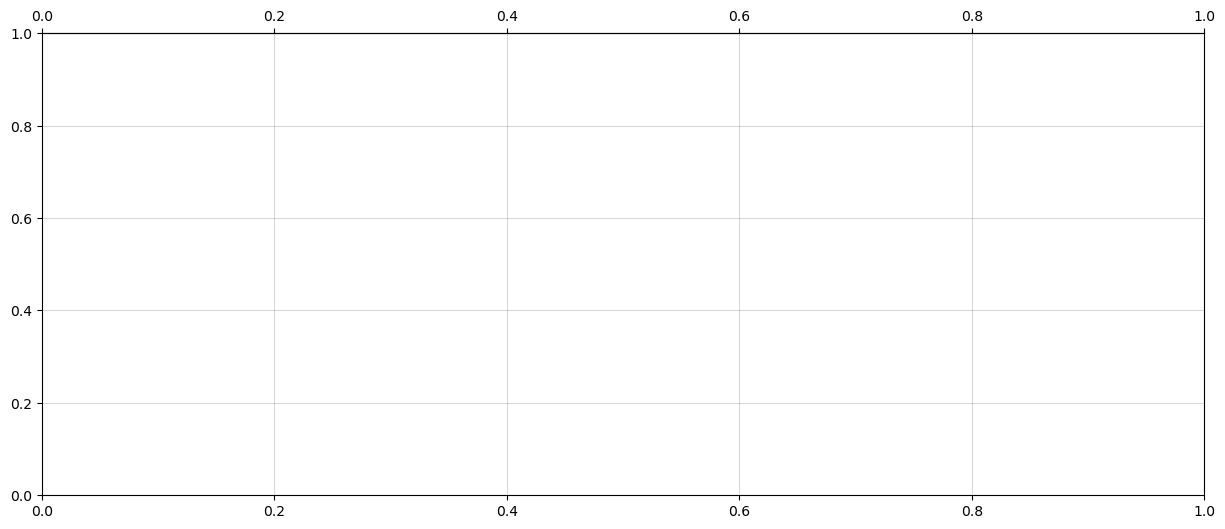

In [7]:
# MAIN 

for MS_FDR in MS_FDR_:
    for MS_strategy in MS_strategy_:
        param_MS.edit_MS( MS_FDR, MS_strategy)
        for sample in ['TCGA-25-1319-01A-01R-1565-13', 'TCGA-AO-A0JM-01A-21R-A056-07']:

            # Intermediate paths filtering
            order_file = os.path.join(sample_plot_dir[sample], f'{sample}_Barplot_sorting.tsv.gz')

            # Intermediate data path MS results
            path_data_pep = os.path.join(save_folder, f'data_peptides{MS_FDR}_{MS_strategy}.tsv.gz')
            path_data_kmers = os.path.join(save_folder, f'data_kmers{MS_FDR}_{MS_strategy}.tsv.gz')
            path_data_peptide_rates = os.path.join(save_folder, f'data_peptides-rates{MS_FDR}_{MS_strategy}.tsv.gz')
            path_data_kmers_rates = os.path.join(save_folder, f'data_kmers-rates{MS_FDR}_{MS_strategy}.tsv.gz')

            # Read data and plot
            group_cols = ['filter_', 'pipeline']
            target_cols = ['validation_rate']
            for suffix, path_data in zip(['kmer', 'tryp-pep'], [path_data_kmers_rates, path_data_peptide_rates]):
                print(f' Reading {path_data}')
                df = pd.read_csv(path_data, sep = '\t')
                display(df.head())
                df = calculate_mean_std(df, group_cols, target_cols)
                param_MS.edit_pep_type(suffix)
                param_object.edit_marker(marker_type="x", marker_size=6, markeredgewidth=2)

                df_plot = run_sample_plotting_rates(order_file, sample, df, param_MS, param_object)
            
            # Read data and plot
            group_cols = ['filter_']
            target_cols = ['pep_size_ohsu', 'pep_size_eth', 'pep_size_intersection', 
                              'pep_size_ohsu\eth', 'pep_size_eth\ohsu']
            for suffix, path_data in zip(['kmer', 'tryp-pep'], [path_data_kmers, path_data_pep]):

                print(f' Reading {path_data}')
                df = pd.read_csv(path_data, sep = '\t')
                display(df.head())
                df = calculate_mean_std(df, group_cols, target_cols)
                param_MS.edit_pep_type(suffix)
                param_object.edit_marker(marker_type = "_", marker_size = 10, markeredgewidth=3)
                df_plot = run_sample_plotting_overlap(order_file, sample, df, param_MS, param_object)


In [ ]:
%debug

> /cluster/customapps/biomed/grlab/users/prelotla/software/miniconda/envs/pep3/lib/python3.9/site-packages/matplotlib/axes/_base.py(498)_plot_args()
    496 
    497         if x.shape[0] != y.shape[0]:
--> 498             raise ValueError(f"x and y must have same first dimension, but "
    499                              f"have shapes {x.shape} and {y.shape}")
    500         if x.ndim > 2 or y.ndim > 2:

ipdb> u
> /cluster/customapps/biomed/grlab/users/prelotla/software/miniconda/envs/pep3/lib/python3.9/site-packages/matplotlib/axes/_base.py(312)__call__()
    310                 this += args[0],
    311                 args = args[1:]
--> 312             yield from self._plot_args(this, kwargs)
    313 
    314     def get_next_color(self):

ipdb> u
> /cluster/customapps/biomed/grlab/users/prelotla/software/miniconda/envs/pep3/lib/python3.9/site-packages/matplotlib/axes/_axes.py(1632)plot()
   1630         """
   1631         kwargs = cbook.normalize_kwargs(kwargs, mlines.Line2D)
-

ipdb> d
> /cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py(152)plot_intersection_bars()
    150         plt.bar(index, intersection, width=width, 
    151                 color=param.color1, label=param.intersection_label)
--> 152     plt.plot(index, eth, alpha=1, color=param.color3,
    153              linestyle = 'None', markerfacecolor='None', marker=param.marker_type,
    154              markersize=param.marker_size, markeredgewidth=param.markeredgewidth,

ipdb> eth
0     0.65
2     0.63
4     0.63
6     0.63
8     0.70
10    0.69
12    0.69
14    0.54
16    0.53
18    0.53
20    0.53
22    0.57
24    0.54
26    0.52
28    0.52
30    0.52
32    0.57
34    0.57
36    0.56
38    0.53
40    0.51
42    0.51
44    0.51
46    0.52
48    0.51
50    0.51
52    0.51
54    0.57
56    0.58
58    0.54
60    0.53
62    0.55
64    0.55
66    0.54
68    0.55
Name: validation_rate, dtype: float64
ipdb> len(eth)
35
ipd